In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import ttest_ind
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn import tree
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn import neighbors
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import pairwise_distances


import datetime
import pydotplus
from sklearn import ensemble

import warnings

%matplotlib inline
sns.set()

warnings.filterwarnings('ignore')
import time

## Introduction

With over 300,000 passengers on the average weekday, New Jersey Transit is one of the largest train systems in the United States.  Despite its size, NJ Transit does not offer granular train performance data to the public.  Pranav Badami has been scraping NJ Transit data for years and making it available at https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance/version/4.  This project aims to determine if the available data can be used to predict train performance, or more specifically, if the train will be ontime vs. running late.  If the data could be used in such a way, it could help to provide delay or cancellation notifications to millions of riders.

## Data Exploration

In [3]:
trains_df = (pd.read_csv('Data/AmtrakNJ/2018_04.csv'))
df_trains = trains_df

In [4]:
#preliminary examination of the data frame

print(
    df_trains.head(),
    df_trains.info(),
    df_trains.describe()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256267 entries, 0 to 256266
Data columns (total 13 columns):
date              256267 non-null object
train_id          256267 non-null object
stop_sequence     242793 non-null float64
from              256267 non-null object
from_id           256267 non-null int64
to                256267 non-null object
to_id             256267 non-null int64
scheduled_time    242793 non-null object
actual_time       256267 non-null object
delay_minutes     242793 non-null float64
status            256267 non-null object
line              256267 non-null object
type              256267 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 25.4+ MB
         date train_id  stop_sequence                   from  from_id  \
0  2018-04-01     7837            1.0  New York Penn Station      105   
1  2018-04-01     7837            2.0  New York Penn Station      105   
2  2018-04-01     7837            3.0     Secaucus Upper Lvl    38187   
3

In [5]:
#checking for missing values in the data

missing_values_ratios = (df_trains.isnull().sum()/df_trains.isnull().count())
missing_values_ratios.sort_values(ascending=False).head()

delay_minutes     0.052578
scheduled_time    0.052578
stop_sequence     0.052578
type              0.000000
line              0.000000
dtype: float64

In [6]:
#very low percentage of missing values; drop them

df_trains.dropna(inplace=True)

In [7]:
#converting the time data from object to datetime, and then to integer for algorithmic friendliness

df_trains['scheduled_time']=pd.to_datetime(df_trains['scheduled_time'])
df_trains['actual_time']=pd.to_datetime(df_trains['actual_time'])
df_trains['date']=pd.to_datetime(df_trains['date'])

In [8]:
df_trains['scheduled_time']=df_trains['scheduled_time'].astype(np.int64)
df_trains['actual_time']=df_trains['actual_time'].astype(np.int64)
df_trains['date']=df_trains['date'].astype(np.int64)

Below, we examine the numerical variables through histograms.

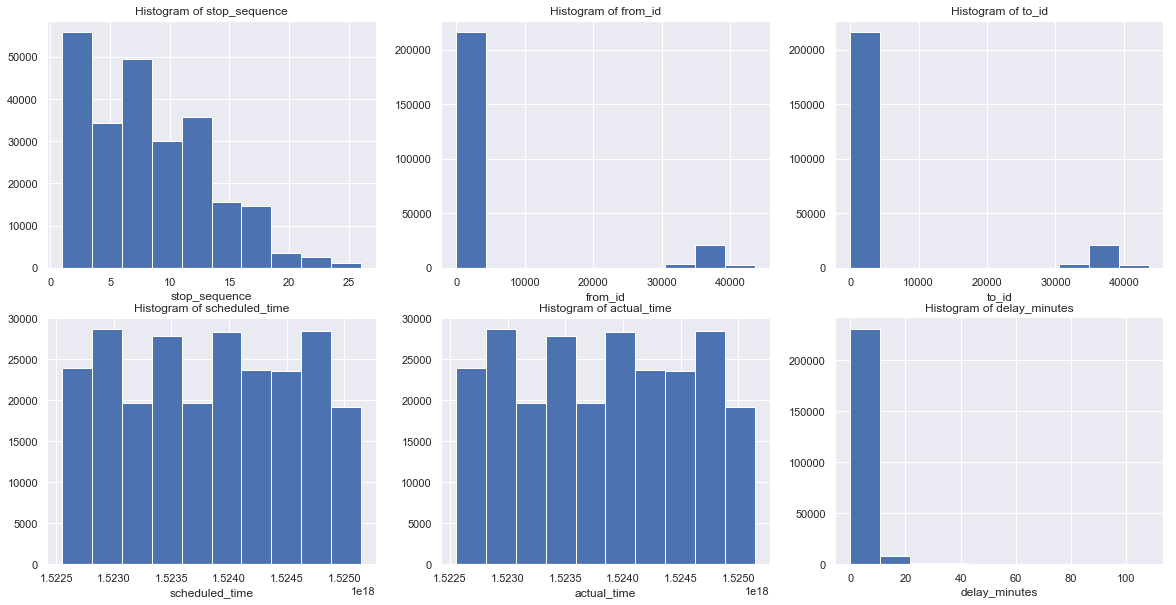

In [9]:
#plotting the numerical data in histograms

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df_trains.stop_sequence)
plt.title("Histogram of {}".format("stop_sequence"))
plt.xlabel('stop_sequence')

plt.subplot(2,3,2)
plt.hist(df_trains.from_id)
plt.title("Histogram of {}".format("from_id"))
plt.xlabel('from_id')

plt.subplot(2,3,3)
plt.hist(df_trains.to_id)
plt.title("Histogram of {}".format("to_id"))
plt.xlabel('to_id')

plt.subplot(2,3,4)
plt.hist(df_trains.scheduled_time)
plt.title("Histogram of {}".format("scheduled_time"))
plt.xlabel('scheduled_time')

plt.subplot(2,3,5)
plt.hist(df_trains.actual_time)
plt.title("Histogram of {}".format("actual_time"))
plt.xlabel('actual_time')

plt.subplot(2,3,6)
plt.hist(df_trains.delay_minutes)
plt.title("Histogram of {}".format("delay_minutes"))
plt.xlabel('delay_minutes')

plt.show()

While technically numerical data, the variables 'stop_sequence', 'from_id', and 'to_id' are more categorical in character.  The variables 'scheduled_time' and 'actual_time' have already been pre-engineered into the useful 'delay_minutes', which is the only true continuous variable in this data set.  

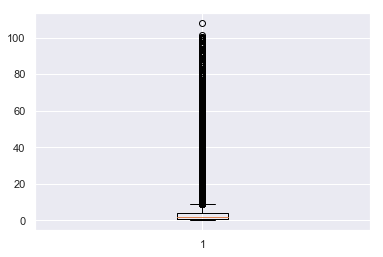

In [10]:
plt.boxplot(df_trains['delay_minutes'])
plt.show()

The histogram and boxplot of 'delay_minutes' show that although delays of more than a few minutes are uncommon, there are occasional significant outliers.  

In [11]:
df_trains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242793 entries, 0 to 256261
Data columns (total 13 columns):
date              242793 non-null int64
train_id          242793 non-null object
stop_sequence     242793 non-null float64
from              242793 non-null object
from_id           242793 non-null int64
to                242793 non-null object
to_id             242793 non-null int64
scheduled_time    242793 non-null int64
actual_time       242793 non-null int64
delay_minutes     242793 non-null float64
status            242793 non-null object
line              242793 non-null object
type              242793 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 25.9+ MB


In [12]:
df_trains['type'].value_counts()

NJ Transit    242793
Name: type, dtype: int64

The 'type' variable has only one value, so it will be excluded from analysis.

Below, we show bar plots of the other categorical variables, 'status' and 'line'.

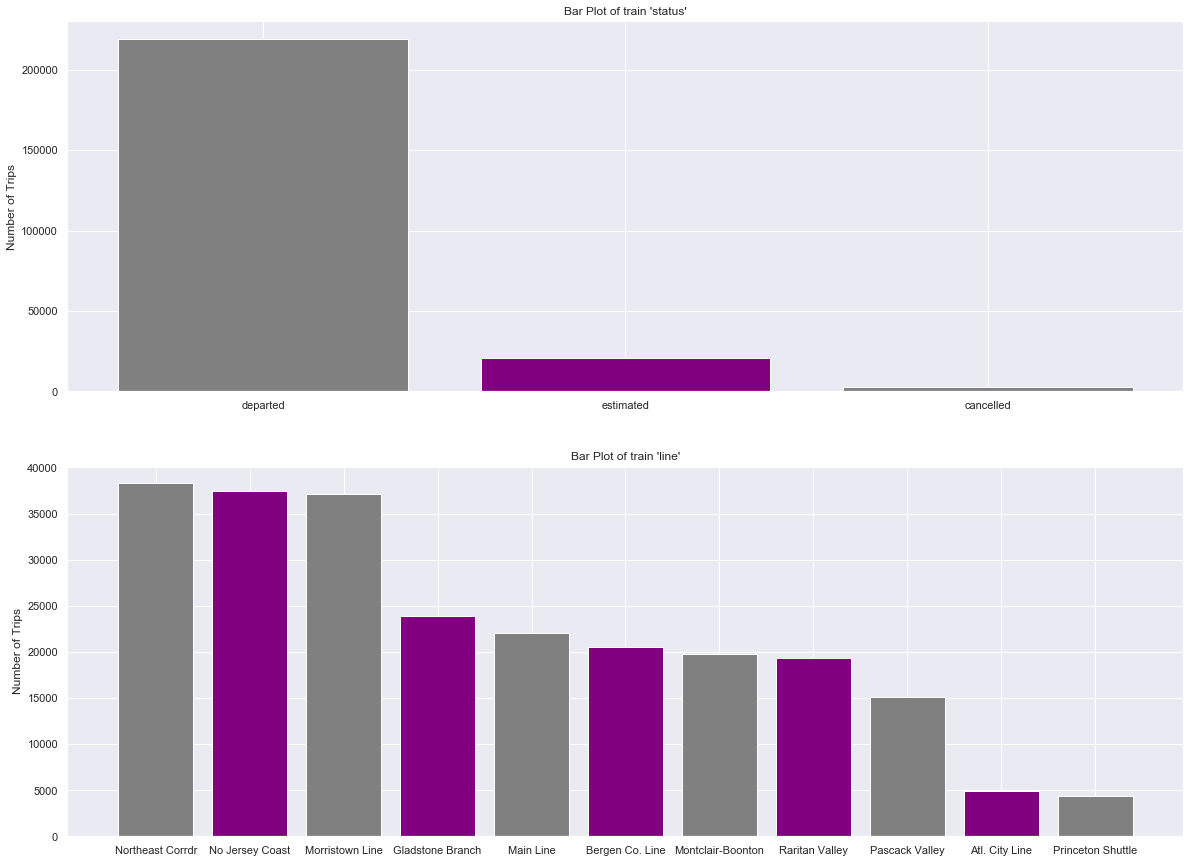

In [13]:
plt.figure(figsize=(20,15))

plt.subplot(2,1,1)
plt.title("Bar Plot of train 'status'")
plt.ylabel('Number of Trips')
plt.bar(np.arange(3), df_trains['status'].value_counts(), color=("grey","purple"))
plt.xticks(np.arange(3), ('departed','estimated','cancelled'))

plt.subplot(2,1,2)
plt.title("Bar Plot of train 'line'")
plt.ylabel('Number of Trips')
plt.bar(np.arange(11), df_trains['line'].value_counts(), color=("grey","purple"))
plt.xticks(np.arange(11), ('Northeast Corrdr','No Jersey Coast','Morristown Line','Gladstone Branch',
                        'Main Line','Bergen Co. Line','Montclair-Boonton','Raritan Valley',
                        'Pascack Valley','Atl. City Line','Princeton Shuttle'))
plt.show()

In [14]:
#the value counts for the variable 'status'
df_trains['status'].value_counts()

departed     219266
estimated     20803
cancelled      2724
Name: status, dtype: int64

Cancelled trains are two orders of magnitude less frequent than departed trains.  Instead of resampling the data to deal with class imbalance in an effort to predict 'cancelled' status, this report will instead attempt to determine if a train is running later than 2.15 minutes.  This value was chosen to deal with class imbalance, as it splits the data almost 50/50 as shown below.

## Feature Engineering

In [15]:
#Make a boolean version of the target for algorithmic friendliness
delay_minutes_bool = []

for idx, val in enumerate(df_trains['delay_minutes']):
    if val > 2.15:
        delay_minutes_bool.append(1)
    else:
        delay_minutes_bool.append(0)
        
df_trains['delay_minutes_bool'] = delay_minutes_bool

In [16]:
df_trains['delay_minutes_bool'].value_counts()

0    125184
1    117609
Name: delay_minutes_bool, dtype: int64

In [17]:
#make dummy variables from the object variables

df_trains = pd.concat([df_trains,pd.get_dummies(
    df_trains[['status','line']], drop_first=True)], axis=1)

In [18]:
df_trains.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242793 entries, 0 to 256261
Data columns (total 26 columns):
date                      242793 non-null int64
train_id                  242793 non-null object
stop_sequence             242793 non-null float64
from                      242793 non-null object
from_id                   242793 non-null int64
to                        242793 non-null object
to_id                     242793 non-null int64
scheduled_time            242793 non-null int64
actual_time               242793 non-null int64
delay_minutes             242793 non-null float64
status                    242793 non-null object
line                      242793 non-null object
type                      242793 non-null object
delay_minutes_bool        242793 non-null int64
status_departed           242793 non-null uint8
status_estimated          242793 non-null uint8
line_Bergen Co. Line      242793 non-null uint8
line_Gladstone Branch     242793 non-null uint8
line_Main Line 

In [19]:
X = pd.concat([df_trains[['date', 'stop_sequence', 'from_id', 'to_id']], df_trains.select_dtypes(['uint8'])], axis=1, sort=False)
             
y = df_trains['delay_minutes_bool']

In [20]:
X_norm = normalize(X)

In [21]:
n_comps = np.arange(15)
param_grid_pca = [{'pca__n_components':n_comps}]
pipe_tree_pca = make_pipeline(PCA())

In [26]:
gs_pca = GridSearchCV(pipe_tree_pca, param_grid=param_grid_pca, cv=10)

In [27]:
gs_pca.fit(X_norm,y)
print(gs_pca.best_params_)

{'pca__n_components': 14}


In [22]:
#using the results of GridSearchCV to perform PCA

sklearn_pca = PCA(n_components=14)  
X_pca = sklearn_pca.fit_transform(X_norm)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)

#X_pca is now our PCA engineered feature set.

The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [5.41347954e-01 4.58651951e-01 9.19632078e-08 5.50298482e-10
 5.14542324e-10 4.99794437e-10 4.24069210e-10 3.28195438e-10
 3.07145635e-10 2.93898254e-10 2.83588059e-10 2.29345338e-10
 6.12298681e-11 1.89701578e-11]


In [23]:
# Split the data into four equally-sized samples for analysis with silhouette. 
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

In [24]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.1,
    random_state=42)

## Model 1: Unsupervised Clustering

In [223]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.8267134917015787
0.8264582873683031
0.8258517763571647
0.8247374516493243


In [224]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=4, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.9853015060546815
0.9855159265534013
0.9856611206667235
0.9857549096821756


In [225]:
for sample in [X_pca1, X_pca2, X_pca3, X_pca4]:
    model = KMeans(n_clusters=6, random_state=42).fit(sample)
    labels_test = model.labels_
    print(metrics.silhouette_score(sample, labels_test, metric='euclidean'))

0.9663471524445826
0.968366486425796
0.9683230817633839
0.9693749070650881


Silhouette analysis seems relatively ambivalent to the number of clusters from 2-6. We will use six clusters for our model.

In [32]:
y_pred = KMeans(n_clusters=6).fit(X_train)
labels = y_pred.labels_

In [33]:
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_train, labels))

Comparing k-means clusters against the data:
col_0                   0      1      2    3     4     5
delay_minutes_bool                                      
0                   88432  10639   9277  715  1634  2094
1                   82299   9571  10917  218  1614  1103


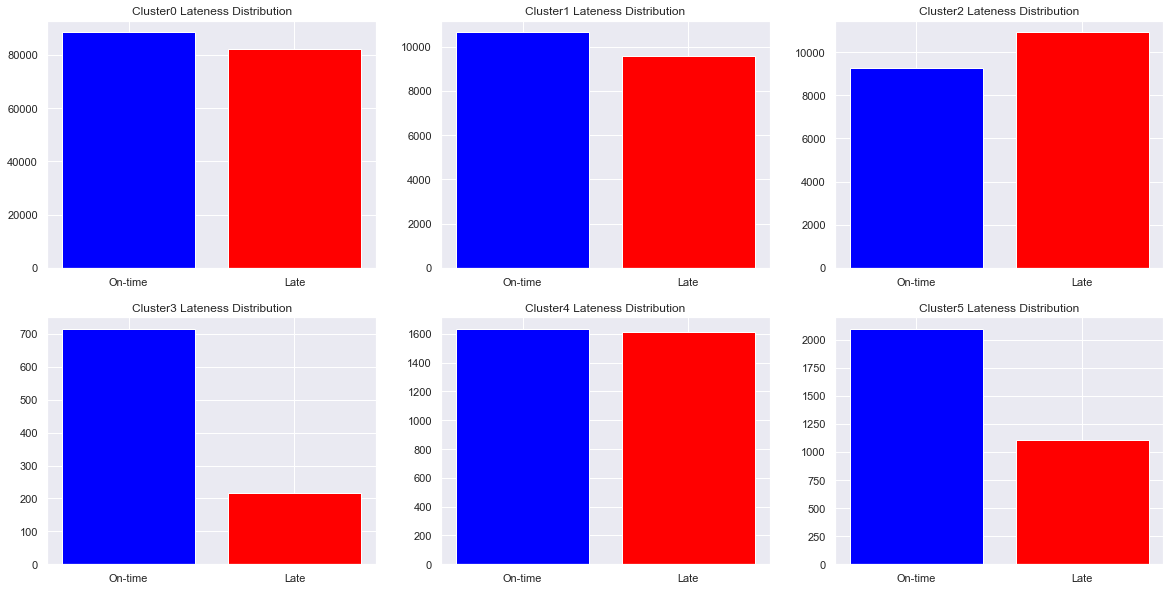

In [37]:
n1 = np.arange(2)
c0_lateness = [88432,82299]
c1_lateness = [10639,9571]
c2_lateness = [9277,10917]
c3_lateness = [715,218]
c4_lateness = [1634,1614]
c5_lateness = [2094,1103]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.bar(n1, c0_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster0 Lateness Distribution')

plt.subplot(2,3,2)
plt.bar(n1, c1_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster1 Lateness Distribution')

plt.subplot(2,3,3)
plt.bar(n1, c2_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster2 Lateness Distribution')

plt.subplot(2,3,4)
plt.bar(n1, c3_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster3 Lateness Distribution')

plt.subplot(2,3,5)
plt.bar(n1, c4_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster4 Lateness Distribution')

plt.subplot(2,3,6)
plt.bar(n1, c5_lateness, color=("blue","red"))
plt.xticks(n1, ('On-time', 'Late'))
plt.title('Cluster5 Lateness Distribution')

plt.show()

In general, the unsupervised analysis is not classifying well between on-time and late.  Cluster0 contains the majority of the dataset, about 75%.  Clusters 3 and 5 show some discrimination of the target variable among a small subset of the data. Below we try some supervised models.

## Model 2: Decision Tree

In [33]:
#setting up parameters for GridSearchCV(DecisionTreeClassifier())

depths = np.arange(1, 25)
num_features = [1, 2]

param_grid_dt_pca = [{'decisiontreeclassifier__max_depth':depths,
               'decisiontreeclassifier__max_features':num_features}]

pipe_tree_dt_pca = make_pipeline(tree.DecisionTreeClassifier(criterion='entropy'))

In [34]:
gs_dt_pca = GridSearchCV(pipe_tree_dt_pca, param_grid=param_grid_dt_pca, cv=10)

In [35]:
gs_dt_pca.fit(X_train,y_train)
print(gs_dt_pca.best_params_)

{'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__max_features': 1}


In [107]:
#initialize and train the decision tree model using GridSearchCV results

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=1
)

decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [108]:
#making predictions for model evaluation
y_pred_dt = decision_tree.fit(X_train, y_train).predict(X_test)

In [109]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(decision_tree, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(decision_tree, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51617627 0.51615413 0.51617775 0.51617775 0.51617775 0.51617775
 0.51617775 0.51617775 0.51617775 0.51617775]
The 10-fold cross validation average for the training set is  0.5161752390889882
--- 1.0046520233154297 seconds ---


In [110]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(decision_tree, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(decision_tree, X_test, y_test, cv=10).mean())

[0.51049815 0.51049815 0.51049815 0.51029654 0.51029654 0.51029654
 0.51029654 0.5105068  0.5105068  0.5105068 ]
The 10-fold cross validation average for the testing set  is  0.510420099915708


In [112]:
#classification report

print(classification_report(y_test, y_pred_dt, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12393
           1       0.00      0.00      0.00     11887

    accuracy                           0.51     24280
   macro avg       0.26      0.50      0.34     24280
weighted avg       0.26      0.51      0.34     24280



In [113]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_dt, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[12393     0]
 [11887     0]]


In the classification reports, a value of 1 corresponds to a value of "late" for the target variable "delay", and 0 corresponds to a "on-time."  Although decision tree models tend to handle varied types of data well, this model isn't achieving any useful discrimination of the target. 

## Model 3: Random Forest Classifier

In [114]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
#making predictions for model evaluation
y_preds_rfc=rfc.predict(X_test)

In [116]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(rfc, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(rfc, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51617627 0.51615413 0.51617775 0.51617775 0.51617775 0.51617775
 0.51617775 0.51617775 0.51617775 0.51617775]
The 10-fold cross validation average for the training set is  0.5161752390889882
--- 7.489235162734985 seconds ---


In [117]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(rfc, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(rfc, X_test, y_test, cv=10).mean())

[0.51049815 0.51049815 0.51049815 0.51029654 0.51029654 0.51029654
 0.51029654 0.5105068  0.5105068  0.5105068 ]
The 10-fold cross validation average for the testing set  is  0.510420099915708


In [118]:
#classification report

print(classification_report(y_test, y_preds_rfc, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12393
           1       0.00      0.00      0.00     11887

    accuracy                           0.51     24280
   macro avg       0.26      0.50      0.34     24280
weighted avg       0.26      0.51      0.34     24280



In [119]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_rfc, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[12393     0]
 [11887     0]]


Similarly to the decision tree model, the random forest model is not a good fit for this data.  It was unable to discriminate the target variable whatsoever with this dataset. 

## Model 4: SVM

In [24]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = [1,2]
param_grid_svm = [{'svc__degree':degrees}]
pipe_tree_svm = make_pipeline(SVC(kernel = 'poly'))

In [25]:
gs_svm = GridSearchCV(pipe_tree_svm, param_grid=param_grid_svm, cv=10)

#gs_svm.get_params().keys()

In [39]:
gs_svm.fit(X_train,y_train)
print(gs_svm.best_params_)

{'svc__degree': 1}


In [25]:
svm = SVC(kernel='poly',degree=1)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [26]:
#Setting the predictions for analysis
y_pred_svm = svm.fit(X_train, y_train).predict(X_test)

#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(svm, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(svm, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

In [27]:
#evaluating the model performance through xvalidation of the testing set

start_time = time.time()

print(cross_val_score(svm, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(svm, X_test, y_test, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.51049815 0.51049815 0.51049815 0.51029654 0.51029654 0.51029654
 0.51029654 0.5105068  0.5105068  0.5105068 ]
The 10-fold cross validation average for the testing set  is  0.510420099915708
--- 204.898530960083 seconds ---


In [28]:
#classification report

print(classification_report(y_test, y_pred_svm, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68     12393
           1       0.00      0.00      0.00     11887

    accuracy                           0.51     24280
   macro avg       0.26      0.50      0.34     24280
weighted avg       0.26      0.51      0.34     24280



In [29]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_pred_svm, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[12393     0]
 [11887     0]]


Similarly to the decision tree and random forest models above, the SVM model was completely unable to classify the target variable.

## Model 5: Naive Bayes

In [49]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_preds_nb = bnb.predict(X_test)

In [50]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(bnb, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(bnb, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.58175079 0.58186894 0.57361219 0.57937852 0.5853279  0.57896664
 0.57809711 0.58166674 0.58088875 0.58207862]
The 10-fold cross validation average for the training set is  0.5803636201065616
--- 1.8319790363311768 seconds ---


In [51]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(bnb, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(bnb, X_test, y_test, cv=10).mean())

[0.5751338  0.57760395 0.57842734 0.59390445 0.58319605 0.5601318
 0.57372323 0.57560775 0.59250103 0.58508447]
The 10-fold cross validation average for the testing set  is  0.579531385014587


In [52]:
#classification report

print(classification_report(y_test, y_preds_nb, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57     12393
           1       0.56      0.60      0.58     11887

    accuracy                           0.58     24280
   macro avg       0.58      0.58      0.58     24280
weighted avg       0.58      0.58      0.58     24280



In [53]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_nb, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[6857 5536]
 [4770 7117]]


Naive Bayes is known for its ability to solve problems with multiple classes of data, and while it may be a stretch to say that it is working well here, it is the first model implemented in this report to begin to achieve some classification of the target variable.

## Model 6: KNN

In [40]:
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
num_neighbors = np.arange(1, 25)
weights = ['distance','uniform']
leaf_sizes = np.arange(1, 40)

param_grid_knn = [{'kneighborsclassifier__n_neighbors':num_neighbors,
                      'kneighborsclassifier__weights':weights,
                      'kneighborsclassifier__leaf_size':leaf_sizes}
                     ]
pipe_tree_knn = make_pipeline(neighbors.KNeighborsClassifier())

In [41]:
gs_knn = GridSearchCV(pipe_tree_knn, param_grid=param_grid_knn, cv=10)

#gs_knn.get_params().keys()

In [42]:
gs_knn.fit(X_train,y_train)
print(gs_knn.best_params_)

{'kneighborsclassifier__leaf_size': 4, 'kneighborsclassifier__n_neighbors': 21, 'kneighborsclassifier__weights': 'uniform'}


In [43]:
#{'kneighborsclassifier__leaf_size': 29, 'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'distance'}
knn = neighbors.KNeighborsClassifier(n_neighbors=21, weights='distance', leaf_size=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=4, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='distance')

In [44]:
# Classify, storing the result in a new variable.
y_preds_knn = knn.predict(X_test)

In [45]:
#evaluating the model performance through xvalidation of the training set

start_time = time.time()

print(cross_val_score(knn, X_train, y_train, cv=10))
print('The 10-fold cross validation average for the training set is ', 
      cross_val_score(knn, X_train, y_train, cv=10).mean())

print("--- %s seconds ---" % (time.time() - start_time))

[0.64265776 0.64030752 0.64386069 0.6430827  0.64674386 0.64866596
 0.64363187 0.64596586 0.64807103 0.64116059]
The 10-fold cross validation average for the training set is  0.6444147836573124
--- 21.463364839553833 seconds ---


In [46]:
#evaluating the model performance through xvalidation of the testing set

print(cross_val_score(knn, X_test, y_test, cv=10))
print('The 10-fold cross validation average for the testing set  is ', 
      cross_val_score(knn, X_test, y_test, cv=10).mean())

[0.62247839 0.63359407 0.62371346 0.61985173 0.6276771  0.61285008
 0.60914333 0.62752369 0.62834775 0.62257932]
The 10-fold cross validation average for the testing set  is  0.6227758922916855


In [47]:
#classification report

print(classification_report(y_test, y_preds_knn, labels=None, target_names=None, 
                      sample_weight=None, digits=2, output_dict=False
                     ))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66     12393
           1       0.64      0.62      0.63     11887

    accuracy                           0.64     24280
   macro avg       0.64      0.64      0.64     24280
weighted avg       0.64      0.64      0.64     24280



In [48]:
#confusion matrix
print('Test set confusion matrix:', '\n', 
      confusion_matrix(y_test, y_preds_knn, labels=None, sample_weight=None)
     )

Test set confusion matrix: 
 [[8316 4077]
 [4550 7337]]


Like the Naive Bayes model, KNN is easy to implement for problems with multiple classes of data, and it also requires no data assumptions.  These characteristics may help to explain why it is working moderately well with this challenging data set.  

## Conclusion

With this dataset, the KNN model dramatically outperformed all other models, including the unsupervised clustering model, in terms of classification performance.  Its precision and recall values are around 0.64, which is not ideal, but it is much better than the other models, and it is well balanced.  To improve the performance of this model, some additional data might need to be scraped and incorporated into the feature set.  Weather data such as precipitation potential or a weather category would be a good starting point for improving the model.